In [1]:
import os
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import html
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

from torch.optim.lr_scheduler import LambdaLR

# import spacy
from typing import List
!pip install sacrebleu
from tqdm import tqdm
import sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.3 MB/s eta 0:00:00


In [9]:
print(f"CPU Cores: {os.cpu_count()}")

CPU Cores: 4



# Pre-processing
The data is kinda clean tho NO IT IS NOT
#TODO 
 - [ ] số liệu thống kê về dữ liệu và từ điển: số câu, vocab size (thật), độ dài câu (min/max/mean), số token?
 - [ ] xử lý dữ liệu
 - [ ] train tokenizer với vocab size lớn hơn / ko vocab size. tokenizer ngắn nên dịch bị lỗi \<unk>
 - [ ] cache tokenization để train ngay
 - [ ] length-based batching để giảm padding
 - [x] real validation data if tst2013 is too small
 - [x] câu ngắn nhất là '\ '
 - [x] bỏ các câu quá dài (có cần k?) (ko)

In [2]:
D_MODEL = 128
VOCAB_SIZE = 20000
D_FF = 1024
LAYERS=6
H=4
WARMUP = 4000

BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# just sooooooooo many custom rules
# mostly deal with html tag remains. someone cleaned the data but kinda messed it up?
def clean_sentence(text):
    currtext = ""
    pattern = re.compile(r'&(?:\s*amp\s*;)+', re.IGNORECASE) # a lot of amp
    while (currtext != text):
        currtext = text
        text = re.sub(r'&amp;\s*lt\s*;\s*em\s*&amp;\s*gt\s*;\s*', r'<', text) # change &amp &amp lt to &lt to unescape later 
        text = re.sub(r'&amp;\s*lt\s*;\s*/\s*em\s*&amp;\s*gt\s*;\s*', r'>', text) # same but for &gt
        text = re.sub(r'&\s+', '&', text) # cut space between & and whatever (not ideal but idc)
        # text = pattern.sub(r'\'', text) 
        # text = re.sub(r'&apos;', r"'",text)
        # text = html.unescape(text) # why is this here? at this point i'm too scared to change it
        text = re.sub(r'\s+>', '>', text)
        text = re.sub(r'>(?=\w)', '> ', text)         # add space after > if followed by a letter
        #drop specific stuffs
        text = re.sub(r'<>','', text)
        text = re.sub(r'< ; i> ;', '', text) 
        text = re.sub(r' < ; / i> ', '', text)
        text = re.sub(r'< ; / I> ;', '', text)
        text = re.sub(r'<\s*;?\s*a\s+href = [^>]*>', '', text, flags=re.IGNORECASE)
        
        text = re.sub(r'; (.*?) < ; / a> ;', r'\1', text) # drop the </a> tags
        text = re.sub(r'<\s*(.*?)\s*>', r'\1', text) # change <> to ""
        text = re.sub(r'"([^"]*?)\s*([,.])\s*"',r'"\1 " \2',text)
        text = html.unescape(text)
    text = re.sub(r"\b(\w+)\s+'(\w+)\b", r"\1'\2", text)
    return text

text = " and I don &apos;t care what the politicians spout ."
clean_sentence(text)

" and I don't care what the politicians spout ."

In [4]:
# file_en_path = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.en.txt"
# file_vi_path = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.vi.txt"

def load_file(path):
    with open(path, encoding="utf-8") as f:
        lines = [line.rstrip("\n") for line in f]
        lines = [clean_sentence(line) for line in lines]
    return lines

# en = load_file(file_en_path)
# vi = load_file(file_vi_path)

# print(en[:5])
# print(vi[:5])

In [13]:
with open("cleaned_train.vi.txt", "w", encoding="utf-8") as f:
    f.writelines(line + '\n' for line in vi)
with open("cleaned_train.en.txt", "w", encoding="utf-8") as f:
    f.writelines(line + '\n' for line in en)

NameError: name 'vi' is not defined

In [ ]:
# train a tokenizer using sentencepiece lib
# isn't this a bit too easy???
# don't run this cell if tokenizer trained

import sentencepiece as spm
import os

# clean_en_path = '/kaggle/input/iwslt15-clean-data/cleaned_train.en.txt'
# clean_vi_path = '/kaggle/input/iwslt15-clean-data/cleaned_train.vn.txt'

#temporary run
clean_en_path = '/kaggle/working/cleaned_train.en.txt'
clean_vi_path = '/kaggle/working/cleaned_train.vi.txt'
if os.path.getsize(clean_en_path) == 0 or os.path.getsize(clean_vi_path) == 0:
    raise ValueError("input not found???")

input_arg = f"{clean_en_path},{clean_vi_path}"

print(f"Đang train SentencePiece trên: {input_arg}")

spm.SentencePieceTrainer.train(
    input=input_arg,            
    model_prefix="spm_en_vi",
    vocab_size=VOCAB_SIZE,
    model_type="bpe",
    
    character_coverage=1,   
    shuffle_input_sentence=True,
    max_sentence_length=2048,
    num_threads=2,         
    
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,

)


In [5]:
# model_file = "/kaggle/input/iwslt15-clean-data/spm_en_vi.model"
model_file = "/kaggle/input/iwslt-en-vi-2015/spm_en_vi.model"
if not os.path.exists(model_file):
    print("no model found")
else:
    sp = spm.SentencePieceProcessor()
    sp.load(model_file)
    print("tokenizer loaded and ready2go!")

    print(f"Kích thước Vocab: {sp.get_piece_size()}")

    text_test = "Sỗ sã sẵ sì sĩ sí sỉ sặ sằ"
    print(f"Test encode '{text_test}': {sp.encode_as_pieces(text_test)}")
    print(f"Test decode: {sp.decode(sp.encode_as_ids(text_test))}")

tokenizer loaded and ready2go!
Kích thước Vocab: 20000
Test encode 'Sỗ sã sẵ sì sĩ sí sỉ sặ sằ': ['▁S', 'ỗ', '▁s', 'ã', '▁s', 'ẵ', '▁s', 'ì', '▁sĩ', '▁s', 'í', '▁s', 'ỉ', '▁s', 'ặ', '▁s', 'ằ']
Test decode: Sỗ sã sẵ sì sĩ sí sỉ sặ sằ


In [6]:
from torch.utils.data import random_split 
# Định nghĩa các ID đặc biệt khớp với lúc train SentencePiece
PAD_ID = 0
UNK_ID = 1
BOS_ID = 2
EOS_ID = 3

def real_sentence(text):
    size_flag = len(text) > 4
    return bool(re.search(r'\w', text)) and size_flag

class IWSLTDataset(Dataset):
    def __init__(self, src_file, tgt_file, clean=False):
        self.src_lines = []
        self.tgt_lines = []
        
        print("Đang đọc và lọc dữ liệu...")
        with open(src_file, 'r', encoding='utf-8') as fs, \
             open(tgt_file, 'r', encoding='utf-8') as ft:
            
            for s_line, t_line in zip(fs, ft):
                if clean:
                    s_clean = clean_sentence(s_line)
                    t_clean = clean_sentence(t_line)
                    s_clean = s_line.rstrip("\n")
                    t_clean = t_line.rstrip("\n")
                else:
                    s_clean = s_line.rstrip("\n")
                    t_clean = t_line.rstrip("\n")
                
                # Chỉ lấy khi cả 2 câu đều không rỗng sau khi clean
                if real_sentence(s_clean) and real_sentence(t_clean):
                    self.src_lines.append(s_clean)
                    self.tgt_lines.append(t_clean)
        
        print(f"Hoàn tất. Số cặp câu: {len(self.src_lines)}")
        
    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        return self.src_lines[idx], self.tgt_lines[idx]


def collate_batch(batch):
    """
    Hàm này xử lý một batch dữ liệu:
    1. Tokenize text thành list of IDs.
    2. Thêm BOS (Start) và EOS (End) tokens.
    3. Pad (điền số 0) để các câu có độ dài bằng nhau.
    """
    src_batch, tgt_batch = [], []
    
    for src_text, tgt_text in batch:
        src_ids = [BOS_ID] + sp.encode_as_ids(src_text) + [EOS_ID]
        tgt_ids = [BOS_ID] + sp.encode_as_ids(tgt_text) + [EOS_ID]
        
        src_batch.append(torch.tensor(src_ids, dtype=torch.long))
        tgt_batch.append(torch.tensor(tgt_ids, dtype=torch.long))
    
    # Pad sequence: tạo tensor (batch_size x max_seq_len)
    # use pytorch pad_sequence()
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_ID)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_ID)
    
    return src_padded, tgt_padded


train_src_file = "/kaggle/input/iwslt-en-vi-2015/cleaned_train.en.txt"
train_tgt_file = "/kaggle/input/iwslt-en-vi-2015/cleaned_train.vi.txt"

# clean_en_path = '/kaggle/working/cleaned_train.en.txt'
# clean_vi_path = '/kaggle/working/cleaned_train.vi.txt'

# Tạo Dataset
dataset = IWSLTDataset(train_src_file, train_tgt_file)

total_size = len(dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # explicit seed for reproducibility
)


train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # shuffle mỗi epoch?
    collate_fn=collate_batch, 
    num_workers=2,         
    pin_memory=True        # idk, optimization
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,             # DO NOT shuffle validation 
    collate_fn=collate_batch,
    num_workers=2,
    pin_memory=True
)

print(f"Đã tạo DataLoader với {len(train_dataset)} cặp câu. và {len(val_dataset)} cặp câu")
print(f"Số lượng batch mỗi epoch: {len(train_dataloader)}")


Đang đọc và lọc dữ liệu...
Hoàn tất. Số cặp câu: 133111
Đã tạo DataLoader với 106489 cặp câu. và 26622 cặp câu
Số lượng batch mỗi epoch: 6656


# Xây dựng Kiến trúc Transformer
#TODO
- [ ] rotational encoding
- [ ] smoothing loss vs entropy loss
- [x] RMSNorm

In [7]:
import copy
# clone helper
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Attention, Positional Encoding

In [8]:
def attention(query, key, value, mask= None, dropout= None):
    """
    query, key, value: (batch_size x heads x seq_len x d_k )
    mask: ?
    dropout: nn.Dropout module from whichever module using this function
    returns attention output (batch_size x heads x seq_len x d_k)
      and weights
    """

    d_k = query.size(-1) # get head size
    # score = query x key_transpose/ head_size
    score = torch.matmul(query, key.transpose(-2, -1) / math.sqrt(d_k))

    if mask is not None:
        score = score.masked_fill(mask == 0, float('-inf')) # big negative

    # softmax to probabilities
    score = nn.functional.softmax(score, dim = -1)

    if dropout is not None:
        score = dropout(score)
    output = torch.matmul(score, value) # (seq_len x seq_len) @ (seq_len x d_model), no transpose :)
    return output, score # don't really need score

In [9]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [10]:
# query, key, value: (batch_size x heads x seq_len x d_k )
# those tensor shapes are killing me man


class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        assert self.dim % 2 == 0, "RoPE dim must be even"
        theta = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('theta', theta, persistence=False) # if persistence isn't set to false, can't resume training 
        self.register_buffer('cos_sin', None, persistence=False)
        self.max_seq_len = 0


    def build_rope_cache(self, seq_len: int = 4096):
        if self.cos_sin is not None and seq_len <= self.max_seq_len:
            return
        seq_idx = torch.arange(seq_len, device=self.theta.device, dtype= self.theta.dtype)
        idx_theta = torch.einsum('i,j->ij', seq_idx, self.theta) # pos*theta
        self.cos_sin = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim = -1)
        self.max_seq_len = seq_len
        
    def forward(self, x):
        seq_len = x.shape[-2] # batch x heads x seq_len x d_k, want seq_len
        self.build_rope_cache(seq_len)

        cos = self.cos_sin[:seq_len, :, 0].unsqueeze(0).unsqueeze(0)
        sin = self.cos_sin[:seq_len, :, 1].unsqueeze(0).unsqueeze(0)
        
        x1, x2 = x.chunk(2, dim=-1)

        return torch.cat(
            [x1 * cos - x2 * sin,
             x1 * sin + x2 * cos],
            dim=-1
        )

In [11]:
class MultiHeadedAttention(nn.Module):
  # d_model = embedding dimensions
  def __init__(self, h, d_model, rotary=None, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    self.d_k = d_model // h
    self.h = h
    self.linears = get_clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)
    self.rotary = rotary 

  def forward(self, query, key, value, mask= None, return_attn=False):
    """
    q,k,v: batch_size x seq_length x d_model
    mask?
    output: batch_size x seq_length x d_model
    """
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)

    nbatches = query.size(0)

    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for lin, x in zip(self.linears, (query, key, value))
    ]
      
    if self.rotary is not None:
        query = self.rotary(query)
        key = self.rotary(key)

    # attention on all the projected vectors in batch.
    x, self.attn = attention(
        query, key, value, mask=mask, dropout=self.dropout
    )

    #  "Concat" using a view and apply a final linear.
    x = (
        x.transpose(1, 2)
        .contiguous()
        .view(nbatches, -1, self.h * self.d_k)
    )
    del query
    del key
    del value
    output = self.linears[-1](x)
    if return_attn:
        return output, self.attn
    return output

### Embedding b4 encoder

In [12]:
# embedding before encoder
# lut = lookup table, x is the tensor to look up
#
class Embedding(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embedding, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model
  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model) # why???

## Norm and residual

In [13]:
class LayerNorm(nn.Module):
    # implement layer normalization
    # eps for numerical stability
    def __init__(self, features, eps=1e-6):
      super(LayerNorm, self).__init__()
      self.a_2 = nn.Parameter(torch.ones(features))
      self.b_2 = nn.Parameter(torch.zeros(features))
      self.eps = eps
    def forward(self, x):
      mean = x.mean(-1, keepdim=True)
      std = x.std(-1, keepdim=True)
      return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [14]:
# epsilon for numerical stability (again)
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # (batch, seq_len, dim)
        # the mean of the square along the last dimension
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) # rsqrt is 1/sqrt(x)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x) # safe for sqrt?
        return output * self.weight

In [15]:
class SublayerConnection(nn.Module):
  # residual + norm
  # norm before or after? before!
  """ connect sub layers """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = RMSNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

In [16]:
class PositionwiseFeedForward(nn.Module):
  # add non-linearities to attention
  # just two linear transformation with an activation (ReLU)
  # we can try using something else like SiLU, but can we justify it?
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

## Encoder-Decoder

In [17]:
class Encoder(nn.Module):
    # nn.Module là lớp cơ sở cho tất cả các mạng neural trong PyTorch
    """multiple stacked layers of EncoderLayer"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = get_clones(layer, N)
        self.norm = RMSNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [18]:
class EncoderLayer(nn.Module):
  """a layer of encoder"""
  """self attention then ffw"""
  # size = d_model
  # x is input?
  def __init__(self, size, self_attn, ffw, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.ffw = ffw
    self.sublayer = get_clones(SublayerConnection(size, dropout), 2)
    self.size = size
  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # q,k,v is the same!
    return self.sublayer[1](x, lambda x: self.ffw(x))


In [19]:
class DecoderLayer(nn.Module):
  # self-explanatory
  # needs mask for self-attention
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = get_clones(SublayerConnection(size, dropout), 3)
    def forward(self, x, memory, src_mask, tgt_mask, return_attn=False):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        
        x2, attn = self.src_attn(x, memory, memory, src_mask, return_attn=True) # propagate attn to decoder layer
        x = self.sublayer[1](x, lambda _: x2)
        x = self.sublayer[2](x, self.feed_forward)
        if return_attn:
            return x, attn
        return x

In [20]:
# mask helper
def subsequent_mask(size):
    "Mask out future positions"
    return torch.tril(torch.ones(size, size, dtype=torch.bool)).unsqueeze(0)

In [21]:
class Decoder(nn.Module):
  # cũng nhiều lớp decoder xếp chồng lên nhau
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = get_clones(layer, N)
        self.norm = RMSNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask, return_attn=False):
        all_attn = []
        for layer in self.layers:
            if return_attn:
                x, attn = layer(x, memory, src_mask, tgt_mask, return_attn)
                all_attn.append(attn)
            else:
                x = layer(x, memory, src_mask, tgt_mask)
        x = self.norm(x)
        if return_attn:
            return x, all_attn[-1] # last layer attention only
        return x

In [22]:
class EncoderDecoder(nn.Module):
    """
    wrap the things together
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask, return_attn=False):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask, return_attn=return_attn)

In [23]:
class Generator(nn.Module):
  """final linear + softmax step"""
  def __init__(self, d_model, vocab):
      super(Generator, self).__init__()
      self.proj = nn.Linear(d_model, vocab)
  def forward(self, x):
      return nn.functional.log_softmax(self.proj(x), dim=-1)

# Huấn luyện và Đánh giá
#TODO
- [ ] length penalty for beam search
- [ ] step training, hyperparameter tuning
- [ ] model ensemble

In [24]:
class Batch:
    def __init__(self, src, tgt=None, pad=PAD_ID):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    # hide the PADDING too
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [25]:
def make_model(src_vocab, tgt_vocab, layers , h, d_model , d_ff , dropout = 0.1):
  # just make a model :)
  c = copy.deepcopy
  # rotary_pe = RotaryPositionalEmbedding(d_model // h)
  attn = MultiHeadedAttention(h, d_model) # Pass rotary_pe to attention
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), layers),
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), layers),
    nn.Sequential(Embedding(d_model, src_vocab),c(position)),
    nn.Sequential(Embedding(d_model, tgt_vocab),c(position)),
    Generator(d_model, tgt_vocab),
  )
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
  return model

In [26]:
def make_model_rotary(src_vocab, tgt_vocab, layers , h, d_model , d_ff , dropout = 0.1):
  # just make a model :)
  c = copy.deepcopy
  rotary_pe = RotaryPositionalEmbedding(d_model // h)
  attn = MultiHeadedAttention(h, d_model, rotary_pe) # Pass rotary_pe to attention
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  # position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
    Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), layers),
    Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), layers),
    Embedding(d_model, src_vocab),
    Embedding(d_model, tgt_vocab),
    Generator(d_model, tgt_vocab),
  )
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
  return model

## Beam search

In [27]:
# used in inference
def beam_search(model, memory, src_mask, start_symbol, end_symbol, max_len=100, beam_size=5, alpha= 0.6, beta=0.2, device='cpu'):
    # memory: output of the encoder
    # src_mask: source mask
    # start_symbol: token for <s>
    # end_symbol: token for </s>
    # max_len: maximum length of generated sequence
    # beam_size: number of candidates to keep at each step

    def length_penalty(seq_len, alpha=0.6):
        return ((5 + seq_len) / (5 + 1)) ** alpha
    
    model.eval()

    # Initialize with the start symbol
    ys = torch.full((1, 1), start_symbol, dtype=torch.long, device=device)

    # Store (log_probability, sequence_so_far)
    candidates = [(0.0, ys,  torch.zeros(memory.size(1), device=device))] # zero coverage vector at start

    for _ in range(max_len - 1):
        new_candidates = []
        # Iterate through current best candidates
        for log_prob, current_sequence, coverage in candidates:

            # if the sequence already ended, keep it as is
            if current_sequence[0, -1].item() == end_symbol:
                new_candidates.append((log_prob, current_sequence, coverage))
                continue

            # target mask for the current sequence
            tgt_mask = subsequent_mask(current_sequence.size(-1)).type_as(memory)

            # Decode the next token
            out, attn = model.decode(memory, src_mask, current_sequence, tgt_mask, return_attn=True)
            step_attn = attn.mean(dim=1)[:, -1, :] #(batch, heads, tgt_len, src_len)
            
            prob = model.generator(out[:, -1]) # Get probabilities for the last token
            log_probs = prob.log_softmax(dim=-1) # Convert to log probabilities

            # Get top 'beam_size' next tokens and their log probabilities
            top_k_log_probs, top_k_indices = log_probs.topk(beam_size)

            for i in range(beam_size):
                next_token_log_prob = top_k_log_probs[0, i].item()
                next_token = top_k_indices[0, i].item()

                extended_sequence = torch.cat(
                    [current_sequence, torch.full((1, 1), next_token, dtype=torch.long, device=device)], dim=1
                )
                new_coverage = coverage + step_attn.squeeze(0) # accumulate average

                len_penalty = length_penalty(extended_sequence.size(1), alpha)
                coverage_penalty = beta * torch.sum(torch.log(torch.clamp(new_coverage, max=1.0)))
                
                # Extend the current sequence with the new token

                new_score = (log_prob + next_token_log_prob) / len_penalty + coverage_penalty
                new_candidates.append((new_score, extended_sequence, new_coverage))

        # Sort all new candidates by new scoring!!! and select the top beam_size
        candidates = sorted(new_candidates, key=lambda x: x[0], reverse=True)[:beam_size]

        # If all best candidates have ended, stop early
        if all(cand[1][0, -1].item() == end_symbol for cand in candidates):
            break

    # Return the best sequence (highest log probability)
    return candidates[0][1].cpu().squeeze().tolist()


In [28]:
def rate(step, d_model, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        d_model ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [29]:
#loss
# is it self.cls - 2 or -1 ? 
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx = 0, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

tạo val dataset ở trên, k chạy cell này

In [30]:
# import os
# # 1. Đường dẫn file Validate
# val_src_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2012.en.txt"
# val_tgt_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2012.vi.txt"

# # 2. Tạo Dataset và DataLoader
# # Lưu ý: Batch size cho Val có thể gấp đôi Train vì không cần lưu Gradient (ít tốn RAM hơn)
# if os.path.exists(val_src_file):
#     val_dataset = IWSLTDataset(val_src_file, val_tgt_file)
    
#     val_dataloader = DataLoader(
#         val_dataset,
#         batch_size=64, # Để 64 cho nhanh, nếu OOM thì giảm xuống 32
#         shuffle=False, # Validate không cần shuffle
#         collate_fn=collate_batch,
#         num_workers=2,
#         pin_memory=True
#     )
#     print(f"Validation DataLoader created. Size: {len(val_dataset)}")
# else:
#     raise ValueError("Không tìm thấy file tst2012!")

## Hàm Train

- [ ] có nên in loss mỗi x (500, 1000) steps thay vì mỗi epoch?
- [ ] explain scheduler, đồ thị cho LR trong report!!!
- [ ] tune hyperparameters from validation
- [x] bỏ tối ưu độ dài câu (<150)
- [ ] gradient accumulation?
- [ ] gradient clipping?
- [x] reload scaler?

In [31]:
# used below to save checkpoints
save_dir = "/kaggle/working/checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [32]:
import time


#validation cannot use smoothing
val_criterion = nn.CrossEntropyLoss(
ignore_index=PAD_ID,
reduction="mean"   # IMPORTANT
)


HISTORY_PATH = "/kaggle/working/history"
HISTORY_FILE = os.path.join(HISTORY_PATH, "history.json")
os.makedirs(HISTORY_PATH, exist_ok= True)
def save_history(history, path=HISTORY_FILE):
    with open(path, "w") as f:
        json.dump(history, f, indent=2)

def train_with_validation_and_checkpointing(
    model, train_dataloader, val_dataloader, criterion, optimizer, lr_scheduler, scaler,
    device, pad_idx, sp_model, num_epochs, sample_sentence,
    start_epoch=0, best_val_loss=float('inf')
):
    """
    train 1 epoch??? 
    """

    
    model.train()
    
    # khởi tạo history để lưu kết quả
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_ppl": [],
        "epoch_time": []
    }

    # gradient_norm = []
    
    model_internal = model.module if hasattr(model, 'module') else model
    
    print(f"{'*'*3} Training from epoch {start_epoch + 1} {'*'*3}")
    for epoch in range(start_epoch, num_epochs):
        print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")
        epoch_start = time.time()
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_dataloader, desc="Training") # just prog. bar

        ckpt_path = os.path.join(
        save_dir,
        f"checkpoint_epoch_{epoch+1}.pth"
        ) 
        
        for i, batch_data in enumerate(pbar):
            src, tgt = batch_data[0].to(device), batch_data[1].to(device)
            
            batch = Batch(src, tgt, pad=pad_idx)
            with torch.amp.autocast(device_type="cuda"):
            # with autocast():
                out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
                out = model_internal.generator(out)
                loss = criterion(out.contiguous().view(-1, out.size(-1)), batch.tgt_y.contiguous().view(-1))
            del out
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # # testing gradient norm for learning with and without warmup
            # scaler.unscale_(optimizer)
            # total_norm = torch.norm(
            #     torch.stack([
            #         p.grad.detach().norm(2)
            #         for p in model.parameters()
            #         if p.grad is not None
            #     ]),
            #     2
            # )
            # gradient_norm.append(total_norm)

            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"loss": loss.item(), "lr": optimizer.param_groups[0]["lr"]})
            
        avg_train_loss = train_loss / len(train_dataloader)

        avg_val_loss, val_ppl = evaluate_loss(model, val_dataloader, val_criterion, device, pad_idx)
        
        print(f"KẾT QUẢ EPOCH {epoch+1}:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss:   {avg_val_loss:.4f} (Perplexity: {val_ppl:.2f})")

        if epoch % 2 == 0 or num_epochs - epoch <= 3:
            torch.save({
                'epoch': epoch + 1, # Lưu epoch kế tiếp sẽ chạy
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'scaler_state_dict' : scaler.state_dict(),
                'best_val_loss': best_val_loss,
            }, ckpt_path)
        
        # Lưu checkpoint tốt nhất (dựa trên val_loss)
        if avg_val_loss < best_val_loss:
            print(f" Loss giảm ({best_val_loss:.4f} -> {avg_val_loss:.4f}). Lưu best checkpoint!")
            best_val_loss = avg_val_loss
            # # Gói tất cả vào một dictionary
            # torch.save({
            #     'epoch': epoch + 1,
            #     'model_state_dict': model.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'scheduler_state_dict': lr_scheduler.state_dict(),
            #     'best_val_loss': best_val_loss,
            # }, "best_checkpoint.pth")
        else:
            print(f" Loss không giảm (Best: {best_val_loss:.4f}).")
            
        # Lưu kết quả vào history
        epoch_time = time.time() - epoch_start
        history["epoch_time"].append(epoch_time)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_ppl"].append(val_ppl)
        save_history(history)
        # 4. Dịch thử
        if sp_model:
            try:
                pred = translate_sentence(sample_sentence, model, sp_model, device)
                print(f"   - Dịch thử: {pred}")
            except: pass
            
    print(f"\nTraining hoàn tất! Best Val Loss: {best_val_loss:.4f}")
    return history

## Evaluate 
#TODO
- [ ] change the damn name
- [ ] more metrics? TER, METEOR, COMET, BERTscore?

In [33]:
import math

def evaluate_loss(model, val_dataloader, criterion, device, pad_idx = PAD_ID):
    """
    Chạy model trên validation data để tính Loss và Perplexity và?
    """
    model.eval() 
    total_loss = 0.0
    model_internal = model.module if hasattr(model, 'module') else model
    with torch.no_grad(): # ko gradient
        for batch_data in val_dataloader:
            src, tgt = batch_data[0].to(device), batch_data[1].to(device)
            batch = Batch(src, tgt, pad=pad_idx)
            
            # fw patch
            out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
            out = model_internal.generator(out)
            
            # Tính Loss
            loss = criterion(out.contiguous().view(-1, out.size(-1)), 
                             batch.tgt_y.contiguous().view(-1))

            total_loss += loss.item()
            
    avg_loss = total_loss / len(val_dataloader)
    
    # Tính Perplexity (PPL) = exp(Loss)
    # PPL càng thấp càng tốt
    try:
        ppl = math.exp(avg_loss)
    except OverflowError:
        ppl = float('inf')
        
    model.train() # failsafe về train
    return avg_loss, ppl

In [34]:
import random

def calculate_scores(model, dataset, tokenizer, alpha, beta, device, num_samples=100):
    """
    Tính BLEU Score và chrF trên một tập mẫu
    Args:
        num_samples: Số lượng câu muốn test (để 100-200 cho nhanh)
    """
    print(f"Đang tính BLEU score trên {num_samples} câu ngẫu nhiên...")
        
    refs = []       # Danh sách câu gốc (Reference)
    preds = []      # Danh sách câu máy dịch (Prediction)
    
    # 2. Lấy mẫu ngẫu nhiên từ dataset
    # Nếu dataset nhỏ hơn num_samples thì lấy hết
    indices = random.sample(range(len(dataset)), min(len(dataset), num_samples))
    
    model.eval()
    print(f"Model Device: {next(model.parameters())}")    
    print(f"Kích thước Vocab: {tokenizer.get_piece_size()}")

    # 3. Chạy vòng lặp dịch
    for i in tqdm(indices, desc="Translating"):
        src_text = dataset.src_lines[i] # Câu tiếng Anh
        tgt_text = dataset.tgt_lines[i] # Câu tiếng Việt gốc (Đáp án)
        try:
            # Dịch
            pred_text = translate_sentence(src_text, model, tokenizer, device, max_len = 100, alpha = alpha, beta = beta)
            
            preds.append(pred_text)
            # BLEU yêu cầu reference là một list
            # Ở đây ta chỉ có 1 đáp án nên để list chứa 1 string
            refs.append([tgt_text]) 
            
        except Exception as e:
            print(f"Lỗi ở index {i}: {e}")
            continue

    bleu = sacrebleu.corpus_bleu(preds, refs)
    chrf = sacrebleu.corpus_chrf(preds, refs)
    
    print(f"BLEU score: {bleu.score:.2f}")
    print(f"chrF score: {chrf.score:.2f}")
    
    return {
            "bleu": bleu.score,      # This is a float (0-100)
            "chrf": chrf.score,      # This is a float (0-100)
            "predictions": preds,    # Keep these for manual checking
            "references": refs
        }

In [35]:
def calculate_scores_faster(
    model,
    dataset,
    tokenizer,
    device,
    num_samples=100,
    batch_size=16
):
    print(f"Evaluating on {num_samples} random samples (batch={batch_size})")

    model.eval()
    refs, preds = [], []

    indices = random.sample(
        range(len(dataset)),
        min(len(dataset), num_samples)
    )

    with torch.no_grad():
        for start in tqdm(range(0, len(indices), batch_size), desc="Translating"):
            batch_idx = indices[start:start + batch_size]

            src_texts = [dataset.src_lines[i] for i in batch_idx]
            tgt_texts = [dataset.tgt_lines[i] for i in batch_idx]

            try:
                batch_preds = translate_batch(
                    src_texts, model, tokenizer, device
                )
            except Exception as e:
                print(f"Batch error at {batch_idx}: {e}")
                continue

            preds.extend(batch_preds)
            refs.extend([[t] for t in tgt_texts])

    bleu = sacrebleu.corpus_bleu(preds, refs)
    chrf = sacrebleu.corpus_chrf(preds, refs)

    print(f"BLEU: {bleu.score:.2f}")
    print(f"chrF: {chrf.score:.2f}")

    return {
        "bleu": bleu.score,
        "chrf": chrf.score,
        "predictions": preds,
        "references": refs,
    }

In [36]:
from torchmetrics.text import BLEUScore

def calculate_bleu(model, dataset, tokenizer, device, num_samples=100):
    """
    Tính BLEU Score trên một tập mẫu ngẫu nhiên.
    Args:
        num_samples: Số lượng câu muốn test (để 100-200 cho nhanh)
    """
    print(f"Đang tính BLEU score trên {num_samples} câu ngẫu nhiên...")
    
    # 1. Khởi tạo metric
    bleu = BLEUScore(n_gram=4) # Chuẩn BLEU-4
    
    refs = []       # Danh sách câu gốc (Reference)
    preds = []      # Danh sách câu máy dịch (Prediction)
    
    # 2. Lấy mẫu ngẫu nhiên từ dataset
    # Nếu dataset nhỏ hơn num_samples thì lấy hết
    indices = random.sample(range(len(dataset)), min(len(dataset), num_samples))
    
    model.eval()
    
    # 3. Chạy vòng lặp dịch
    for i in tqdm(indices, desc="Translating"):
        src_text = dataset.src_lines[i] # Câu tiếng Anh
        tgt_text = dataset.tgt_lines[i] # Câu tiếng Việt gốc (Đáp án)
        
        try:
            # Dịch
            pred_text = translate_sentence(src_text, model, tokenizer, device)
            
            preds.append(pred_text)
            
            # BLEU yêu cầu reference là một list
            # Ở đây ta chỉ có 1 đáp án nên để list chứa 1 string
            refs.append([tgt_text]) 
            
        except Exception as e:
            print(f"Lỗi ở index {i}: {e}")
            continue

    score = bleu(preds, refs)
    
    print("\n" + "="*30)
    print(f"KẾT QUẢ BLEU SCORE: {score.item():.4f}")
    print("="*30)
    
    return score.item(), preds, refs

## Translate a sentence with trained model and tokenizer.

In [63]:
# IMPORTANT: the tokenizer is from sentencepiece
def translate_sentence(sentence, model, tokenizer, device, max_len=100,alpha=0.6, beta=0.2):
    model.eval()
    
    # tokenize câu đầu vào
    # Thêm BOS và EOS (giống lúc train)
    tokens = [BOS_ID] + tokenizer.encode_as_ids(sentence) + [EOS_ID]
    src = torch.tensor(tokens).long().unsqueeze(0).to(device) # size: (1, seq_len)
    
    # tạo mask để bỏ qua padding
    src_mask = (src != PAD_ID).unsqueeze(-2)
    
    # encode
    with torch.no_grad():
        memory = model.encode(src, src_mask)
        output_ids = beam_search(model, memory, src_mask, BOS_ID, EOS_ID, max_len, beam_size=3, device=device, alpha=alpha, beta=beta)
    
    if EOS_ID in output_ids:
        output_ids = output_ids[:output_ids.index(EOS_ID)]
        
    translation = tokenizer.decode(output_ids)
    
    model.train()
    return translation

In [43]:
def load_checkpoint(model, optimizer, scheduler, scaler, filepath, device='cpu'):
    start_epoch = 0
    best_val_loss = float('inf')
    
    if os.path.exists(filepath):
        print(f"--- Đang tải checkpoint từ: {filepath} ---")
        checkpoint = torch.load(filepath, map_location=device)
        
        # reload các thứ (cần reload gradscaler ko?)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        
        # Lấy thông tin epoch và loss để train tiếp
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        
        print(f" train tiếp từ Epoch {start_epoch + 1}.")
        print(f" Best Val Loss đã ghi nhận: {best_val_loss:.4f}")
        print(f"Learning Rate hiện tại: {optimizer.param_groups[0]['lr']:.6f}")
    else:
        print(" ko tìm thấy checkpoint, train từ đầu")
        
    return start_epoch, best_val_loss


## Plot các thứ

In [39]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Vẽ đồ thị Train Loss, Val Loss, và Val Perplexity.
    """
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    val_ppl = history['val_ppl']
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Perplexity
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_ppl, 'go-', label='Validation Perplexity')
    plt.title('Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("/kaggle/working/metric_graph.png")
    plt.show()


## Khởi tạo model, optimizer, scheduler, train

In [40]:
# LabelSmoothingLoss cần input đúng kích thước vocab
criterion = LabelSmoothingLoss(classes=VOCAB_SIZE, padding_idx=PAD_ID, smoothing=0.0)

model = make_model_rotary(src_vocab=VOCAB_SIZE, tgt_vocab=VOCAB_SIZE, 
                   layers=LAYERS, h=H, d_model=D_MODEL, d_ff=D_FF, dropout=0.1)

# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)
    
# add vào device or sth idk
model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters.")

Model created with 12052512 parameters.


In [41]:
def count_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:50} | {param.numel():>10}")

count_parameters(model)

encoder.layers.0.self_attn.linears.0.weight        |      16384
encoder.layers.0.self_attn.linears.0.bias          |        128
encoder.layers.0.self_attn.linears.1.weight        |      16384
encoder.layers.0.self_attn.linears.1.bias          |        128
encoder.layers.0.self_attn.linears.2.weight        |      16384
encoder.layers.0.self_attn.linears.2.bias          |        128
encoder.layers.0.self_attn.linears.3.weight        |      16384
encoder.layers.0.self_attn.linears.3.bias          |        128
encoder.layers.0.ffw.w_1.weight                    |     131072
encoder.layers.0.ffw.w_1.bias                      |       1024
encoder.layers.0.ffw.w_2.weight                    |     131072
encoder.layers.0.ffw.w_2.bias                      |        128
encoder.layers.0.sublayer.0.norm.weight            |        128
encoder.layers.0.sublayer.1.norm.weight            |        128
encoder.layers.1.self_attn.linears.0.weight        |      16384
encoder.layers.1.self_attn.linears.0.bia

cell này để train

--- Đang tải checkpoint từ: /kaggle/working/checkpoints/checkpoint_epoch_2.pth ---
 train tiếp từ Epoch 3.
 Best Val Loss đã ghi nhận: 1.5671
Learning Rate hiện tại: 0.000766
*** Training from epoch 3 ***

--- Epoch 3/20 ---


Training: 100%|██████████| 6656/6656 [10:06<00:00, 10.98it/s, loss=2.33, lr=0.000626] 


KẾT QUẢ EPOCH 3:
Train Loss: 1.4814
Val Loss:   1.4221 (Perplexity: 4.15)
 Loss giảm (1.5671 -> 1.4221). Lưu best checkpoint!
   - Dịch thử: Các loại thuốc không thể thay đổi cách sử dụng các tế bào gốc .

--- Epoch 4/20 ---


Training: 100%|██████████| 6656/6656 [10:25<00:00, 10.64it/s, loss=1.25, lr=0.000542] 


KẾT QUẢ EPOCH 4:
Train Loss: 1.4419
Val Loss:   1.3846 (Perplexity: 3.99)
 Loss giảm (1.4221 -> 1.3846). Lưu best checkpoint!
   - Dịch thử: Sự thay đổi không thể thay đổi cách mà vũ trụ .

--- Epoch 5/20 ---


Training: 100%|██████████| 6656/6656 [10:39<00:00, 10.41it/s, loss=1.49, lr=0.000485] 


KẾT QUẢ EPOCH 5:
Train Loss: 1.4053
Val Loss:   1.3599 (Perplexity: 3.90)
 Loss giảm (1.3846 -> 1.3599). Lưu best checkpoint!
   - Dịch thử: Sự thay đổi khí hậu không thể thay đổi thế giới .

--- Epoch 6/20 ---


Training: 100%|██████████| 6656/6656 [10:40<00:00, 10.39it/s, loss=2.86, lr=0.000442] 


KẾT QUẢ EPOCH 6:
Train Loss: 1.3790
Val Loss:   1.3402 (Perplexity: 3.82)
 Loss giảm (1.3599 -> 1.3402). Lưu best checkpoint!
   - Dịch thử: Chính phủ không thể thay đổi thế giới không thể thay đổi thế giới .

--- Epoch 7/20 ---


Training: 100%|██████████| 6656/6656 [10:24<00:00, 10.65it/s, loss=1.03, lr=0.000409] 


KẾT QUẢ EPOCH 7:
Train Loss: 1.3603
Val Loss:   1.3249 (Perplexity: 3.76)
 Loss giảm (1.3402 -> 1.3249). Lưu best checkpoint!
   - Dịch thử: T. Sự rõ ràng là không thay đổi toàn cầu của vũ trụ .

--- Epoch 8/20 ---


Training: 100%|██████████| 6656/6656 [10:13<00:00, 10.84it/s, loss=0.754, lr=0.000383]


KẾT QUẢ EPOCH 8:
Train Loss: 1.3430
Val Loss:   1.3100 (Perplexity: 3.71)
 Loss giảm (1.3249 -> 1.3100). Lưu best checkpoint!
   - Dịch thử: Và vũ khí của sự thay đổi không thể thay đổi được sự chuẩn bị của vũ trụ .

--- Epoch 9/20 ---


Training: 100%|██████████| 6656/6656 [10:27<00:00, 10.60it/s, loss=1.79, lr=0.000361] 


KẾT QUẢ EPOCH 9:
Train Loss: 1.3277
Val Loss:   1.2953 (Perplexity: 3.65)
 Loss giảm (1.3100 -> 1.2953). Lưu best checkpoint!
   - Dịch thử: vũ khí của vũ trụ không thể thay đổi được những vũ khí của vũ trụ .

--- Epoch 10/20 ---


Training: 100%|██████████| 6656/6656 [10:20<00:00, 10.72it/s, loss=1.13, lr=0.000343] 


KẾT QUẢ EPOCH 10:
Train Loss: 1.3184
Val Loss:   1.2839 (Perplexity: 3.61)
 Loss giảm (1.2953 -> 1.2839). Lưu best checkpoint!
   - Dịch thử: vũ trụ của vũ trụ không thể thay đổi vũ trụ .

--- Epoch 11/20 ---


Training: 100%|██████████| 6656/6656 [10:15<00:00, 10.81it/s, loss=1.57, lr=0.000327] 


KẾT QUẢ EPOCH 11:
Train Loss: 1.3025
Val Loss:   1.2718 (Perplexity: 3.57)
 Loss giảm (1.2839 -> 1.2718). Lưu best checkpoint!
   - Dịch thử: Vũ khí của vũ trụ không thể thay đổi thế giới của vũ trụ .

--- Epoch 12/20 ---


Training: 100%|██████████| 6656/6656 [10:39<00:00, 10.41it/s, loss=1.9, lr=0.000313]  


KẾT QUẢ EPOCH 12:
Train Loss: 1.2953
Val Loss:   1.2637 (Perplexity: 3.54)
 Loss giảm (1.2718 -> 1.2637). Lưu best checkpoint!
   - Dịch thử: vũ khí hạt nhân không thể thay đổi khí hậu không thể thay đổi bản chất của vũ trụ .

--- Epoch 13/20 ---


Training: 100%|██████████| 6656/6656 [10:52<00:00, 10.20it/s, loss=1.5, lr=0.0003]    


KẾT QUẢ EPOCH 13:
Train Loss: 1.2846
Val Loss:   1.2510 (Perplexity: 3.49)
 Loss giảm (1.2637 -> 1.2510). Lưu best checkpoint!
   - Dịch thử: Chính phủ Trung Quốc không thể thay thế giới thay đổi đạo đức của vũ khí .

--- Epoch 14/20 ---


Training: 100%|██████████| 6656/6656 [10:53<00:00, 10.18it/s, loss=1.64, lr=0.00029]  


KẾT QUẢ EPOCH 14:
Train Loss: 1.2723
Val Loss:   1.2467 (Perplexity: 3.48)
 Loss giảm (1.2510 -> 1.2467). Lưu best checkpoint!
   - Dịch thử: vũ khí của vũ trụ không thể thay đổi thế giới toàn cầu về vũ trụ .

--- Epoch 15/20 ---


Training: 100%|██████████| 6656/6656 [10:54<00:00, 10.16it/s, loss=2.31, lr=0.00028]  


KẾT QUẢ EPOCH 15:
Train Loss: 1.2639
Val Loss:   1.2399 (Perplexity: 3.46)
 Loss giảm (1.2467 -> 1.2399). Lưu best checkpoint!
   - Dịch thử: Hệ thống đạo đức không thể thay đổi bản chất của vũ trụ .

--- Epoch 16/20 ---


Training: 100%|██████████| 6656/6656 [10:50<00:00, 10.22it/s, loss=1.22, lr=0.000271] 


KẾT QUẢ EPOCH 16:
Train Loss: 1.2521
Val Loss:   1.2334 (Perplexity: 3.43)
 Loss giảm (1.2399 -> 1.2334). Lưu best checkpoint!
   - Dịch thử: Hệ thống của sự không thể thay đổi sự thay đổi của vũ trụ .

--- Epoch 17/20 ---


Training: 100%|██████████| 6656/6656 [10:43<00:00, 10.34it/s, loss=1.9, lr=0.000263]  


KẾT QUẢ EPOCH 17:
Train Loss: 1.2484
Val Loss:   1.2281 (Perplexity: 3.41)
 Loss giảm (1.2334 -> 1.2281). Lưu best checkpoint!
   - Dịch thử: vũ khí của vũ trụ không thể thay thế giới vũ trụ .

--- Epoch 18/20 ---


Training: 100%|██████████| 6656/6656 [10:44<00:00, 10.33it/s, loss=1.28, lr=0.000255] 


KẾT QUẢ EPOCH 18:
Train Loss: 1.2431
Val Loss:   1.2185 (Perplexity: 3.38)
 Loss giảm (1.2281 -> 1.2185). Lưu best checkpoint!
   - Dịch thử: Hệ thống tôn giáo không thể thay thế giới hạn chế .

--- Epoch 19/20 ---


Training: 100%|██████████| 6656/6656 [10:52<00:00, 10.20it/s, loss=1.42, lr=0.000249] 


KẾT QUẢ EPOCH 19:
Train Loss: 1.2361
Val Loss:   1.2138 (Perplexity: 3.37)
 Loss giảm (1.2185 -> 1.2138). Lưu best checkpoint!
   - Dịch thử: Chính phủ không thể thay thế giới hạn của vũ khí .

--- Epoch 20/20 ---


Training: 100%|██████████| 6656/6656 [10:51<00:00, 10.22it/s, loss=1.12, lr=0.000242] 


KẾT QUẢ EPOCH 20:
Train Loss: 1.2296
Val Loss:   1.2099 (Perplexity: 3.35)
 Loss giảm (1.2138 -> 1.2099). Lưu best checkpoint!
   - Dịch thử: vũ khí của vũ trụ không thể thay đổi được vũ trụ của vũ trụ .

Training hoàn tất! Best Val Loss: 1.2099


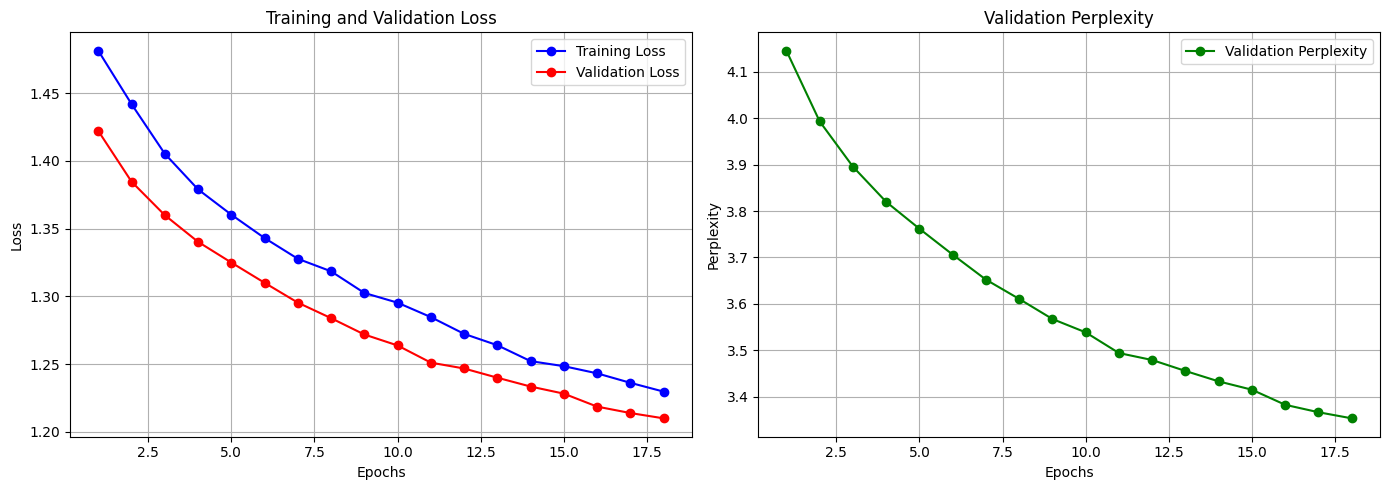

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)
lr_scheduler = LambdaLR(optimizer=optimizer,
    lr_lambda=lambda step: rate(step, d_model=D_MODEL, factor=1, warmup=WARMUP))
scaler = torch.amp.GradScaler("cuda")

start_epoch = 0

checkpoint_path = "/kaggle/working/checkpoints/checkpoint_epoch_2.pth"
start_epoch, best_val_loss = load_checkpoint(model, optimizer, lr_scheduler, scaler, checkpoint_path, device)
# train từ đầu hoặc train tiếp 
history = None
try:
    history = train_with_validation_and_checkpointing(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        criterion=criterion,
        optimizer=optimizer,         # Truyền optimizer đã được load state
        lr_scheduler=lr_scheduler,
        scaler = scaler,
        device=device,
        pad_idx=PAD_ID,
        sp_model=sp,
        num_epochs=20,               # Ví dụ muốn train tổng cộng 20 epochs
        sample_sentence="The weapon of criticism obviously cannot replace the criticism of weapons.",
        start_epoch=start_epoch,     # Bắt đầu từ epoch đã load
        best_val_loss=best_val_loss  # Dùng best_loss đã load để so sánh
    )
except KeyboardInterrupt:
    print("Đang train thì bị ép dừng :(((")
finally:
    if history is not None:
        plot_metrics(history)
    else:
        print("no history found. training failed?")

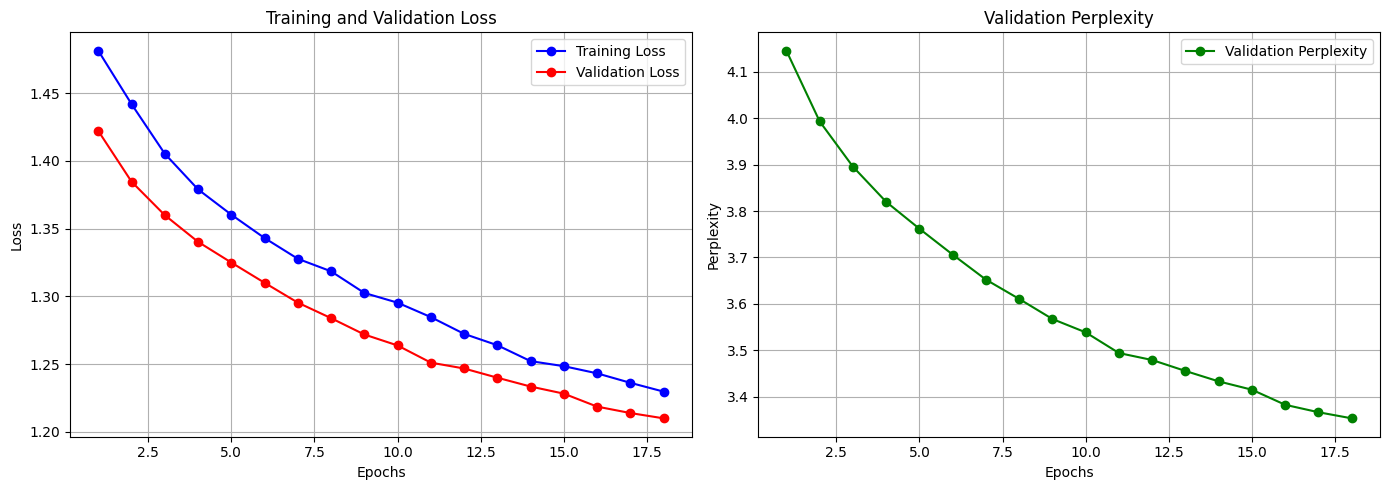

In [45]:
import json
from tabulate import tabulate

with open('/kaggle/working/history/history.json', 'r') as f:
    data = json.load(f)

train_loss = data.get("train_loss", [])
val_loss = data.get("val_loss", [])
val_ppl = data.get("val_ppl", [])

history = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "val_ppl": val_ppl,
}
plot_metrics(history)

In [ ]:
historyfirst2 = 

In [ ]:
# real_history = history[0]

# gradient_norm = history[1]

# gradient = []
# gradient.extend(t.cpu() for t in gradient_norm)

# plt.figure(figsize=(12, 5))
# plt.plot(gradient, color='tab:red', linewidth=1, label='Total Gradient Norm')

# # This helps visualize if your gradients are hitting the ceiling
# # plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Clip Threshold (1.0)')

# plt.title('Gradient Norm per Step')
# plt.xlabel('Training Step (Batch)')
# plt.ylabel('Norm Value')
# plt.grid(True, alpha=0.3)
# plt.legend()

# # If the values are huge at the start, log scale helps you see the detail
# # plt.yscale('log') 
# plt.savefig("/kaggle/working/grad_norm_4kwarmup.png")

# plt.show()

In [ ]:
# serializable_list = [t.detach().cpu().item() for t in gradient]

# with open("/kaggle/working/gradient_norms.json", "w") as f:
#     json.dump(serializable_list, f)

# Test

In [ ]:
# %whos

In [46]:
test_model = make_model_rotary(src_vocab = VOCAB_SIZE, tgt_vocab= VOCAB_SIZE, layers=LAYERS , h=H, d_model=D_MODEL , d_ff=D_FF , dropout = 0.1)
test_optimizer = torch.optim.AdamW(test_model.parameters(), lr=1e-4)
test_scheduler = torch.optim.lr_scheduler.StepLR(test_optimizer, step_size=1)
test_scaler = torch.amp.GradScaler("cuda")
filepath = "/kaggle/working/checkpoints/checkpoint_epoch_20.pth"
load_checkpoint(test_model, test_optimizer, test_scheduler, test_scaler, filepath, device)
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     test_model = nn.DataParallel(test_model)
test_model.to(device)
# test_model.load_state_dict(state_dict)



--- Đang tải checkpoint từ: /kaggle/working/checkpoints/checkpoint_epoch_20.pth ---
 train tiếp từ Epoch 21.
 Best Val Loss đã ghi nhận: 1.2138
Learning Rate hiện tại: 0.000242


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (rotary): RotaryPositionalEmbedding()
        )
        (ffw): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): RMSNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): RMSNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3

In [61]:
test_model.eval()
sentence = ' Scared of these students with their big brains and their big books and their big , unfamiliar words . .'

pred = translate_sentence(sentence, test_model, tokenizer = sp, alpha = 1, beta = 1, device="cuda", max_len=100)
print(pred)
preds = [pred]
refs = [[' Sợ những sinh viên to đầu , những quyển sách to đùng và cả những ngôn từ lạ lẫm .']]
bleu = sacrebleu.corpus_bleu(preds, refs)
print(bleu.score)

Sơ-cơ-lơ này với bộ não của họ và những cuốn sách lớn và những cuốn sách lớn , không còn là những từ ngữ lớn .
2.4294859658214887


In [ ]:
test_src_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2013.en.txt"
test_tgt_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2013.vi.txt"

en_test = load_file(test_src_file)
vi_test = load_file(test_tgt_file)

with open("cleaned_test.vi.txt", "w", encoding="utf-8") as f:
    f.writelines(line + '\n' for line in vi_test)
with open("cleaned_test.en.txt", "w", encoding="utf-8") as f:
    f.writelines(line + '\n' for line in en_test)

In [64]:
clean_test_vi = "/kaggle/input/iwslt-en-vi-2015/cleaned_test.vi_2013.txt"
clean_test_en = "/kaggle/input/iwslt-en-vi-2015/cleaned_test.en_2013.txt"

test_dataset = IWSLTDataset(clean_test_en, clean_test_vi)

results = calculate_scores(
    model=test_model, 
    dataset=test_dataset, 
    tokenizer=sp,
    alpha = 0,
    beta = 0,
    device="cuda", 
    num_samples=len(test_dataset),
)


Đang đọc và lọc dữ liệu...
Hoàn tất. Số cặp câu: 1268
Đang tính BLEU score trên 1268 câu ngẫu nhiên...
Model Device: Parameter containing:
tensor([[-0.2510, -0.1313, -0.4383,  ..., -0.0295,  0.3138, -0.1213],
        [ 0.1734,  0.0824,  0.1478,  ..., -0.0315,  0.0036, -0.1363],
        [ 0.3086, -0.0634,  0.3990,  ...,  0.2219, -0.1555,  0.2722],
        ...,
        [ 0.4540, -0.1328, -0.2463,  ...,  0.0941, -0.0247, -0.1211],
        [-0.1018, -0.1741, -0.0823,  ..., -0.4158, -0.0633,  0.0159],
        [-0.0497,  0.0599, -0.2456,  ...,  0.0113,  0.2131, -0.1019]],
       device='cuda:0', requires_grad=True)
Kích thước Vocab: 20000


Translating: 100%|██████████| 1268/1268 [24:56<00:00,  1.18s/it]


BLEU score: 21.26
chrF score: 29.27


In [ ]:
test_dataset[0:3]

In [ ]:
# test_src_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2013.en.txt"
# test_tgt_file = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/tst2013.vi.txt"

# if os.path.exists(test_src_file):
#     print("Đang tạo Test Dataset...")
#     test_dataset = IWSLTDataset(test_src_file, test_tgt_file, True)
    
#     # 3. Tính BLEU trên tập Test 
#     print("Đang chấm điểm trên tập Test...")
#     score_test, _, _ = calculate_bleu(
#         model=test_model, 
#         dataset=test_dataset, 
#         sp_model=sp, 
#         device=device, 
#         num_samples=len(test_dataset)
#     )
#     print(f"Dataset Test size: {len(test_dataset)}")
# else:
#     print("Không tìm thấy file Test. Bạn hãy kiểm tra lại đường dẫn trong Input.")

In [ ]:
# # Nén toàn bộ file trong working thành output.zip
# os.system("zip -r output.zip .")

# from IPython.display import FileLink
# print("Bấm vào đây để tải trọn bộ (ZIP):")
# FileLink(r'output.zip')